In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch 

import dft_lrp

import synthetic_example

from utils import lrp_utils

from tqdm import tqdm
import matplotlib.pyplot as plt

/home/vielhaben/anaconda3/envs/dft-lrp/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data and model

### Generate synthetic data

In [2]:
signal_length = 2560

In [3]:
freqs_star = np.array([5,16,32,53])  # for label generation

x_train, _, y_train = synthetic_example.generate_signal_data(signal_length=signal_length,  
                                                            max_freq = 64,
                                                            n_freq_min=10,
                                                            n_freq_max=50,
                                                            n=10000,
                                                            weighted_sampling=True,
                                                            weight=1.2,
                                                            random_phase=True,
                                                            uniform_amplitude=True,
                                                            freqs_for_powerset_label=freqs_star,
                                                            noise_strength=0.01)

signal_time, _, y_test = synthetic_example.generate_signal_data(signal_length=signal_length, 
                                                                max_freq = 64,
                                                                n_freq_min=10,
                                                                n_freq_max=50,
                                                                n=100,
                                                                weighted_sampling=True,
                                                                weight=1.2,
                                                                random_phase=True,
                                                                uniform_amplitude=True,
                                                                freqs_for_powerset_label=freqs_star,
                                                                noise_strength=0)

### Train a simple MLP model in time domain

In [4]:
# run training, inference and relevance backprop on cuda
if torch.cuda.is_available():
    cuda = True
    device = torch.device("cuda")
else:
    cuda = False
    device = torch.device("cpu")

In [5]:
model = synthetic_example.train_model(x_train, y_train,  signal_length=signal_length, cnn=False, n_label=16, 
                                        batch_size=128, lr=0.001, n_layer=2, epochs=20, cuda=cuda, binary=False)

epoch: 1, loss: 2.824
epoch: 2, loss: 2.491
epoch: 3, loss: 2.164
epoch: 4, loss: 1.685
epoch: 5, loss: 0.930
epoch: 6, loss: 0.357
epoch: 7, loss: 0.161
epoch: 8, loss: 0.094
epoch: 9, loss: 0.063
epoch: 10, loss: 0.048
epoch: 11, loss: 0.037
epoch: 12, loss: 0.031
epoch: 13, loss: 0.026
epoch: 14, loss: 0.022
epoch: 15, loss: 0.019
epoch: 16, loss: 0.017
epoch: 17, loss: 0.015
epoch: 18, loss: 0.014
epoch: 19, loss: 0.013
epoch: 20, loss: 0.012
Finished Training


Accuracy

In [8]:
with torch.no_grad():
    out = model(torch.tensor(signal_time, dtype=torch.float32, device=device)).cpu().numpy()

test_acc = np.equal(out.argmax(axis=1), y_test).mean()
print("test accuracy: ", test_acc)


test accuracy:  1.0


# XAI in time, frequency and time-frequency domain

### LRP relevances in time domain

In [7]:
batch_size = 100
relevance_time = np.empty((signal_time.shape[0],signal_length))
for b in tqdm(range(0,signal_time.shape[0],batch_size)):
    relevance_time[b:b+batch_size] = lrp_utils.zennit_relevance(signal_time[b:b+batch_size], model, target=y_test[b:b+batch_size], attribution_method='lrp', cuda=cuda)

100%|██████████| 1/1 [00:00<00:00, 52.08it/s]


### DFT-LRP to propagate relevance from time to frequency domain

In [9]:
# create DFTLRP object for DFT and DFT-LRP in pytorch
dftlrp = dft_lrp.DFTLRP(signal_length, 
                        leverage_symmetry=True, 
                        precision=32,
                        create_stdft=False,
                        create_inverse=False
                        )

In [10]:
signal_freq = np.empty((signal_time.shape[0],signal_length//2+1), dtype=np.complex128)
relevance_freq = np.empty((signal_time.shape[0],signal_length//2+1))

for b in tqdm(range(0,signal_time.shape[0],batch_size)):
    signal_freq[b:b+batch_size], relevance_freq[b:b+batch_size] = dftlrp.dft_lrp(relevance_time[b:b+batch_size], signal_time[b:b+batch_size], real=False, short_time=False)

  0%|          | 0/1 [00:00<?, ?it/s]/home/vielhaben/git/DFT-LRP/code/dft_lrp.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=dtype)
100%|██████████| 1/1 [00:00<00:00, 230.65it/s]


In [11]:
del dftlrp    # to free memory before STDFT which requires a lot of memory

### DFT-LRP to propagate relevance from time to time-frequency domain

In [12]:
# create DFTLRP object for STDFT and STDFT-LRP in pytorch
dftlrp = dft_lrp.DFTLRP(signal_length, 
                        leverage_symmetry=True, 
                        precision=32,
                        window_shift=1, 
                        window_width=128, 
                        window_shape='rectangle',
                        create_dft=False,
                        create_inverse=False
                        )

In [13]:
signal_timefreq = np.empty((signal_time.shape[0],20,signal_length//2+1), dtype=np.complex128)
relevance_timefreq = np.empty((signal_time.shape[0],20,signal_length//2+1))

for b in tqdm(range(0,signal_time.shape[0],batch_size)):
    signal_timefreq[b:b+batch_size], relevance_timefreq[b:b+batch_size] = dftlrp.dft_lrp(relevance_time[b:b+batch_size], signal_time[b:b+batch_size], real=False, short_time=True)

100%|██████████| 1/1 [00:00<00:00, 14.94it/s]


### Visualization

In [14]:
def replace_positive(x, positive=True):
    mask = x>0 if positive else x<0
    x_mod = x.copy()
    x_mod[mask] = 0
    return x_mod

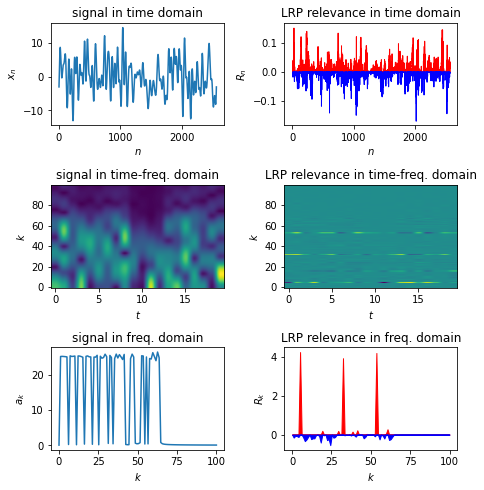

In [15]:
sample_idx = 0

nrows, ncols = 3,2
figsize = (2*3.29, 2*3.29/ncols*nrows*1.4/2)
fig, ax = plt.subplots(nrows,ncols, figsize=figsize)


k_max = 100

x = np.linspace(0,signal_length,signal_length)
ax[0,0].plot(x, signal_time[sample_idx])
ax[0,1].fill_between(x, replace_positive(relevance_time[sample_idx], positive=False), color="red")
ax[0,1].fill_between(x, replace_positive(relevance_time[sample_idx]), color="blue")
ax[0,0].set_xlabel("$n$")
ax[0,1].set_xlabel("$n$")
ax[0,0].set_ylabel("$x_n$")
ax[0,1].set_ylabel("$R_n$")
ax[0,0].set_title('signal in time domain')
ax[0,1].set_title('LRP relevance in time domain')


x =  np.linspace(0,k_max,k_max)
ax[2,0].plot(x, np.abs(signal_freq[sample_idx,:k_max]))
ax[2,1].fill_between(x, replace_positive(relevance_freq[sample_idx,:k_max], positive=False), color="red")
ax[2,1].fill_between(x, replace_positive(relevance_freq[sample_idx,:k_max]), color="blue")
ax[2,0].set_xlabel("$k$")
ax[2,1].set_xlabel("$k$")
ax[2,0].set_ylabel("$a_k$")
ax[2,1].set_ylabel("$R_k$")
ax[2,0].set_title('signal in freq. domain')
ax[2,1].set_title('LRP relevance in freq. domain')

ax[1,0].imshow(np.abs(signal_timefreq[sample_idx,:,:k_max].T), aspect="auto", origin="lower")
ax[1,1].imshow(relevance_timefreq[sample_idx,:,:k_max].T, aspect="auto", origin="lower")
ax[1,0].set_xlabel("$t$")
ax[1,1].set_xlabel("$t$")
ax[1,0].set_ylabel("$k$")
ax[1,1].set_ylabel("$k$")
ax[1,0].set_title('signal in time-freq. domain')
ax[1,1].set_title('LRP relevance in time-freq. domain')

plt.tight_layout()